# Plot Anomalies

This file finds anomalies in a node, according to 4 different methods: `Isolation Forest`, `Extended Isolation Forest`, `Matrix Profile` and `Auto Encoder`, and plot them in intractive way (EC, TEMP, PH, ORP).

**Import Libraries**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import datetime
import folium
import folium
import altair as alt
import pandas as pd
import pickle
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

**Global Variables**

In [2]:
NODE = 1012

**Functions**

In [3]:
def load_point_data(point_id):

    infile = open(f"{point_id}.pkl",'rb')
    df = pickle.load(infile)
    infile.close()
    return(df)

In [4]:
def create_anomaly_df(point_id):

    point_df = load_point_data(
        f'./Data_with_anomalies/{point_id}_data_with_anomalies')
    point_df = point_df[[
        'EC', 'PH', 'ORP', 'TEMPERATURE', 'ALL_DIMS_mp', 'ALL_DIMS_if',
        'auto encoder Anomaly', 'ALL_DIMS_eif'
    ]]

    point_df = point_df.reset_index()
    point_df.set_index('DateTime', inplace=True)
    point_df = point_df.resample('5min').mean()

    point_df[[
        'ALL_DIMS_mp', 'ALL_DIMS_if', 'auto encoder Anomaly', 'ALL_DIMS_eif'
    ]] = point_df[[
        'ALL_DIMS_mp', 'ALL_DIMS_if', 'auto encoder Anomaly', 'ALL_DIMS_eif'
    ]].apply(np.ceil)

    point_df = point_df.rename(
        columns={
            'ALL_DIMS_mp': 'MP',
            'ALL_DIMS_if': 'IF',
            'ALL_DIMS_eif': 'EIF',
            'auto encoder Anomaly': 'AUTO ENCODER'
        })
    point_df = point_df.replace(0.0, np.nan)

    return point_df

In [5]:
def plot_multi_variant_anomalies(point_df):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,
                                             figsize=(40, 8),
                                             gridspec_kw={'hspace': 0.01},
                                             sharex=True)
    fig.suptitle(f'Anomaly Detection\n', fontsize='30')

    ax1.plot(point_df['EC'], color='deeppink')
    ax1.set_ylabel('EC', fontsize='8')

    ax2.plot(point_df['PH'], color='teal')
    ax2.set_ylabel('PH', fontsize='8')

    ax3.plot(point_df['ORP'], color='navy')
    ax3.set_ylabel('ORP', fontsize='8')

    ax4.plot(point_df['TEMPERATURE'], color='mediumorchid')
    ax4.set_ylabel('TEMPERATURE', fontsize='8')
    ax4.set_xlabel('Date', fontsize='15')

    window_color = {
        'AUTO ENCODER': 'red',
        'EIF': 'lightgreen',
        'IF': 'lightskyblue',
        'MP': 'gold'
    }

    rect_legend = []
    for model in ['AUTO ENCODER', 'EIF', 'IF', 'MP']:
        indx = point_df.loc[point_df[model] == 1].index
        for i in indx:
            # Create rectangle x coordinates
            startTime = i - datetime.timedelta(minutes=5 * 12)
            endTime = startTime + datetime.timedelta(minutes=5 * 24)

            # convert to matplotlib date representation
            start = mdates.date2num(startTime)
            end = mdates.date2num(endTime)
            width = end - start

            # Plot rectangle
            rect1 = Rectangle((start, 0),
                              width,
                              7000,
                              color=window_color[model])
            rect2 = Rectangle((start, 0), width, 15, color=window_color[model])
            rect3 = Rectangle((start, -400),
                              width,
                              700,
                              color=window_color[model])
            rect4 = Rectangle((start, 0), width, 30, color=window_color[model])

            ax1.add_patch(rect1)
            ax2.add_patch(rect2)
            ax3.add_patch(rect3)
            ax4.add_patch(rect4)
        rect_legend.append(rect1)

    plt.legend(rect_legend, ['AUTO ENCODER', 'EIF', 'IF', 'MP'],
               bbox_to_anchor=(-0.06, 2))
    plt.show()

    # Anomalies plots
    for model in ['AUTO ENCODER', 'EIF', 'IF', 'MP']:
        df = point_df.reset_index()
        indx = df.loc[df[model] == 1].index
        temp = indx[0]
        for i, num in enumerate(indx):
            if indx[i] > temp + 12:

                fig, (ax1, ax2, ax3,
                      ax4) = plt.subplots(4,
                                          figsize=(14, 4),
                                          gridspec_kw={'hspace': 0},
                                          sharex=True)
                fig.suptitle(
                    f"{model} Anomaly at {df['DateTime'].iloc[num].date()}",
                    fontsize='15')

                ax1.plot(point_df['EC'][num - 12:num + 13], color='deeppink')
                ax1.set_ylabel('EC', fontsize='8')
                ax1.patch.set_facecolor(window_color[model])
                ax1.patch.set_alpha(0.05)

                ax2.plot(point_df['PH'][num - 12:num + 13], color='teal')
                ax2.set_ylabel('PH', fontsize='8')
                ax2.patch.set_facecolor(window_color[model])
                ax2.patch.set_alpha(0.05)

                ax3.plot(point_df['ORP'][num - 12:num + 13], color='navy')
                ax3.set_ylabel('ORP', fontsize='8')
                ax3.patch.set_facecolor(window_color[model])
                ax3.patch.set_alpha(0.05)

                ax4.plot(point_df['TEMPERATURE'][num - 12:num + 13],
                         color='mediumorchid')
                ax4.set_ylabel('TEMPERATURE', fontsize='8')
                ax4.set_xlabel('Date', fontsize='15')
                ax4.patch.set_facecolor(window_color[model])
                ax4.patch.set_alpha(0.1)
                temp = indx[i]
                plt.tight_layout()
                plt.show()


#         print('--------------------------------------------------------------------------------------------------------------------------')

In [6]:
def create_univariant_anomaly_df(point_id):
    
    point_df = load_point_data(f'./Data_with_anomalies/{point_id}_data_with_anomalies')
    point_df = point_df[['EC', 'PH', 'ORP', 'TEMPERATURE', 'EC_mp', 'PH_mp', 'ORP_mp', 
                         'TEMPERATURE_mp', 'EC_if', 'PH_if', 'ORP_if', 'TEMPERATURE_if', 
                         'EC_eif', 'PH_eif', 'ORP_eif', 'TEMPERATURE_eif']]

    point_df = point_df.reset_index()
    for col in ['EC_mp', 'PH_mp', 'ORP_mp', 'TEMPERATURE_mp', 'EC_if', 'PH_if', 'ORP_if',
                'TEMPERATURE_if', 'EC_eif', 'PH_eif', 'ORP_eif', 'TEMPERATURE_eif']:
        ind = point_df[point_df[col] == 1].index

        for i in ind:
            point_df[col].iloc[i-12:i+13] = 1

    if len(point_df) >= 20000:
        RESAMPLE = '15min'
    elif len(point_df) >= 10000:
        RESAMPLE = '10min'
    else:
        RESAMPLE = '5min'

    point_df.set_index('DateTime', inplace=True)
    point_df = point_df.resample(RESAMPLE).mean()
    point_df = point_df.reset_index()
    point_df = point_df.rename(columns={'DateTime': 'date'})

    point_df['EC_legend'] = 'EC'
    point_df['PH_legend'] = 'PH'
    point_df['ORP_legend'] = 'ORP'
    point_df['TEMPERATURE_legend'] = 'TEMPERATURE'

    point_df[['EC_mp', 'PH_mp', 'ORP_mp', 'TEMPERATURE_mp', 'EC_if', 'PH_if', 
              'ORP_if', 'TEMPERATURE_if', 'EC_eif', 'PH_eif', 'ORP_eif', 
              'TEMPERATURE_eif']] = point_df[['EC_mp', 'PH_mp', 'ORP_mp', 'TEMPERATURE_mp', 
                                              'EC_if', 'PH_if', 'ORP_if', 'TEMPERATURE_if', 
                                              'EC_eif', 'PH_eif', 'ORP_eif', 'TEMPERATURE_eif']].apply(np.ceil)

    point_df = point_df.replace(0.0, np.nan)

    for model in ['mp', 'if', 'eif']:
        for feature in ['EC', 'PH', 'ORP', 'TEMPERATURE']:
            for i, row in point_df.iterrows():
                if row[f'{feature}_{model}'] == 1.0:
                    if point_df[f'{feature}_legend'].iloc[i] == feature:                    
                        point_df[f'{feature}_legend'].iloc[i] = model
                    elif point_df[f'{feature}_legend'].iloc[i] == model:
                        continue
                    elif f'{model}+' in point_df[f'{feature}_legend'].iloc[i] or f'+{model}' in point_df[f'{feature}_legend'].iloc[i]:
                        continue
                    else:
                        point_df[f'{feature}_legend'].iloc[i] = point_df[f'{feature}_legend'].iloc[i] + f'+{model}'
    return point_df

In [7]:
def anomaly_graph(df, col):
    
    alt.data_transformers.enable('default', max_rows=None)

    color = alt.Color(f'{col}_legend:N')
    brush = alt.selection_interval(encodings=['x'])
    click = alt.selection_multi(encodings=['color'])

    graph = alt.Chart(
              ).mark_bar(
              ).transform_impute(col, 
                                 key='date', 
                                 value=None, 
                                 groupby=[f'{col}_legend']
              ).encode(alt.X('date:T', title='Date'),
                       alt.Y(f'{col}:Q',
                             title=f'{col}'),
                       color=alt.condition(brush,
                                           color, 
                                           alt.value('lightgray'))
              ).properties(width=350,
                           height=100
              ).add_selection(brush
              ).transform_filter(click)

    anomaly = alt.Chart(
                ).mark_line(
                ).transform_impute(col, 
                                   key='date', 
                                   value=None, 
                                   groupby=[f'{col}_legend']
                ).encode(alt.X('date:T', 
                               title='Date'),
                         alt.Y(f'{col}:Q',
                               title=f'{col}'),
                         color=alt.condition(click, 
                                             f'{col}_legend:N', 
                                             alt.value('lightgray'))
                ).transform_filter(brush
                ).properties(width=350,
                             height=100
                ).add_selection(click)

    concat = alt.hconcat(graph,
                         anomaly,
                         data=df,
                         title=f'{col} Anomaly Detection')
    
    return concat

In [8]:
def create_total_graph(df):    
    graphs = []
    for col in ['PH', 'EC', 'ORP', 'TEMPERATURE']:
        graphs.append(anomaly_graph(df, col))

    anomaly = alt.vconcat(graphs[0],
                          graphs[1],
                          graphs[2],
                          graphs[3]).resolve_scale(color='independent')
    return anomaly

**Plot**

In [9]:
point_df = create_univariant_anomaly_df(NODE)
create_total_graph(point_df)

alt.VConcatChart(...)

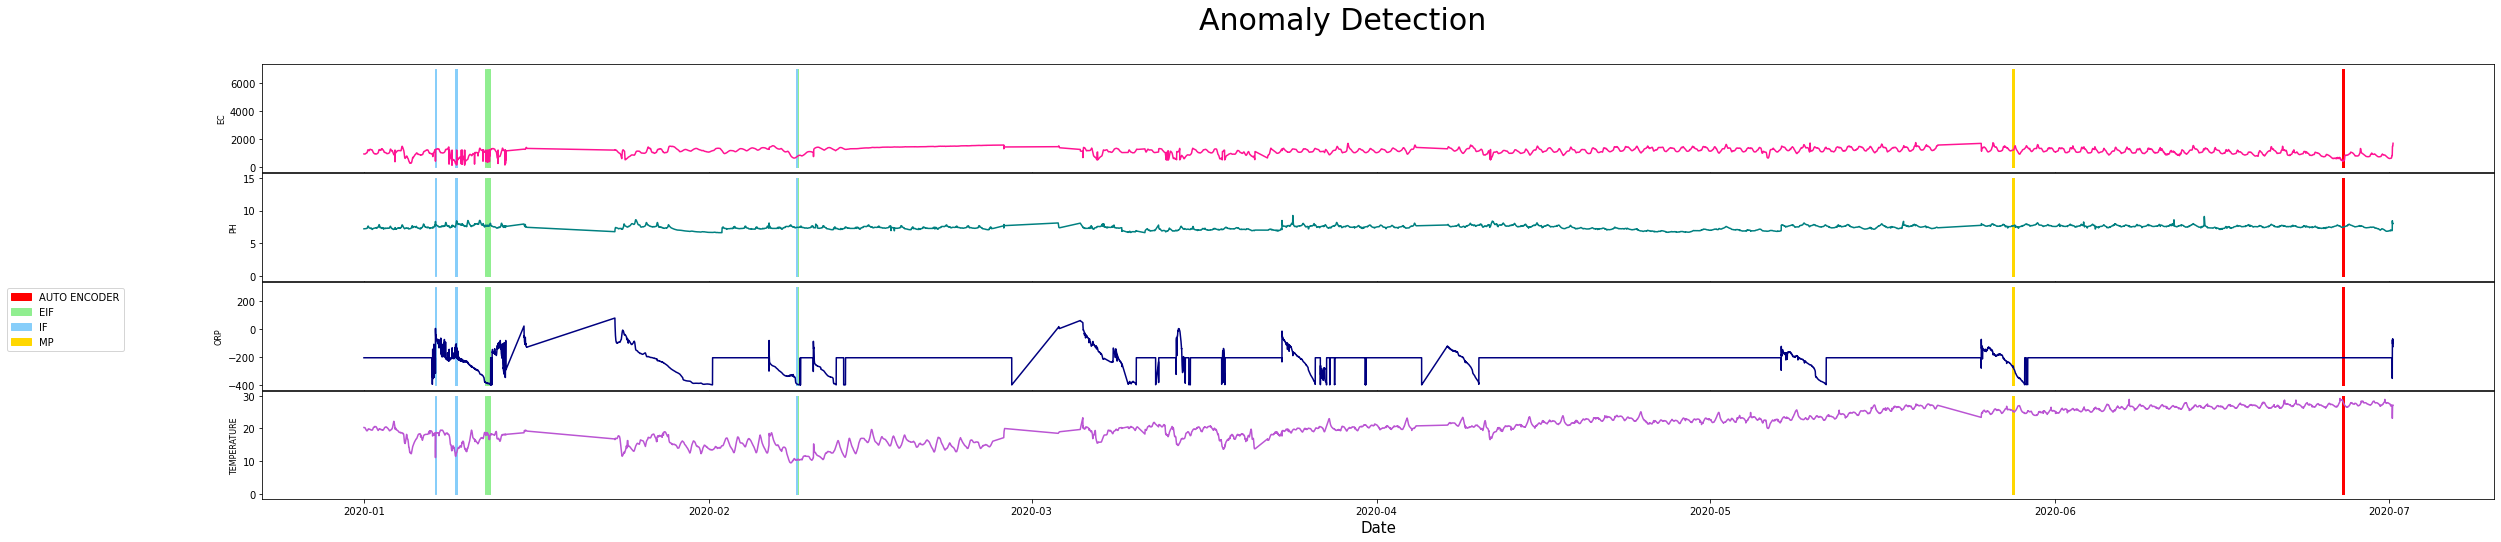

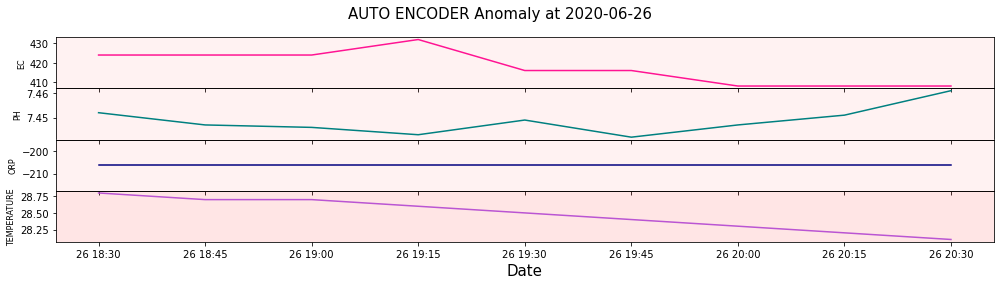

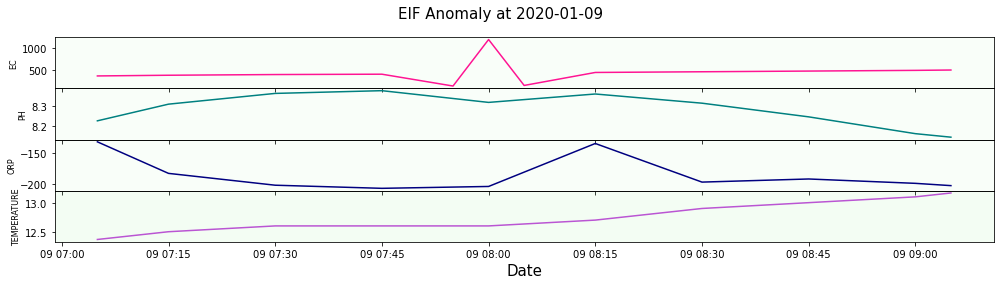

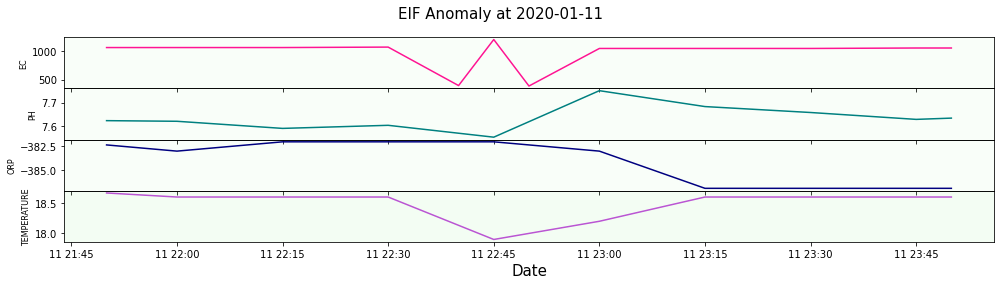

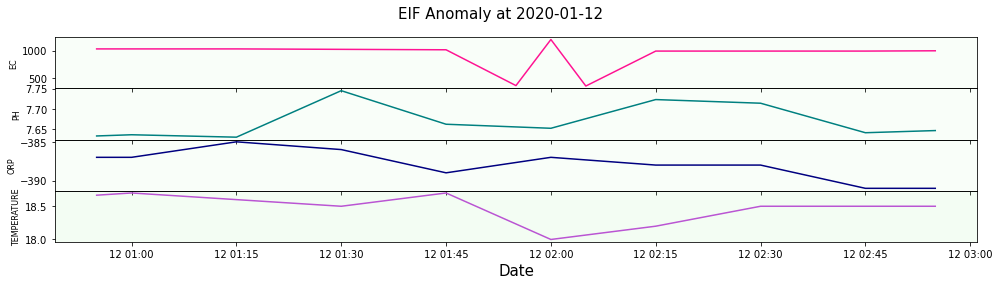

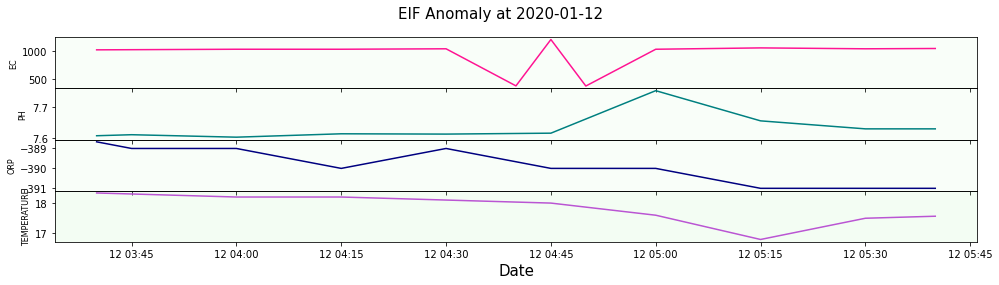

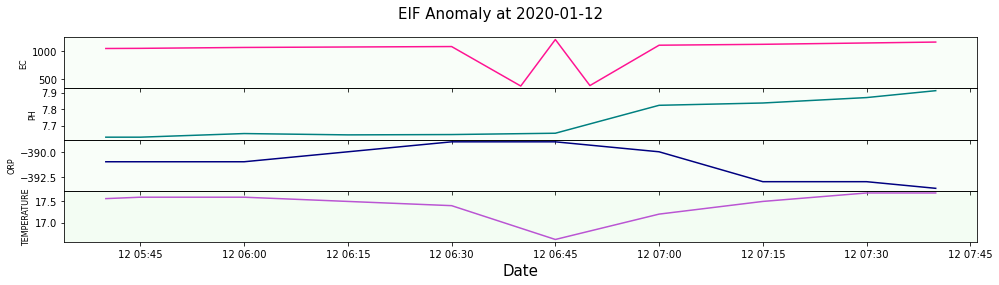

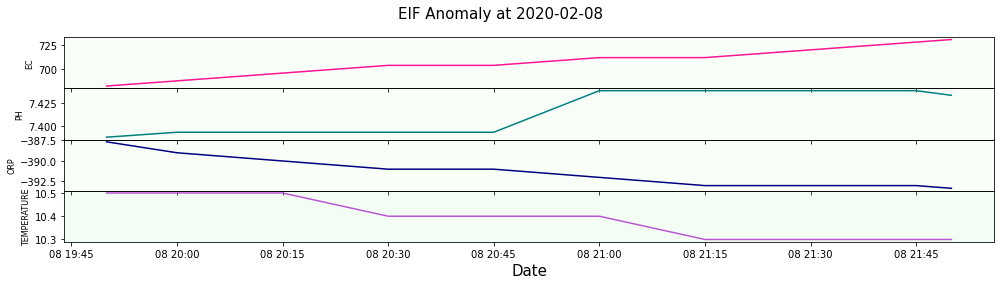

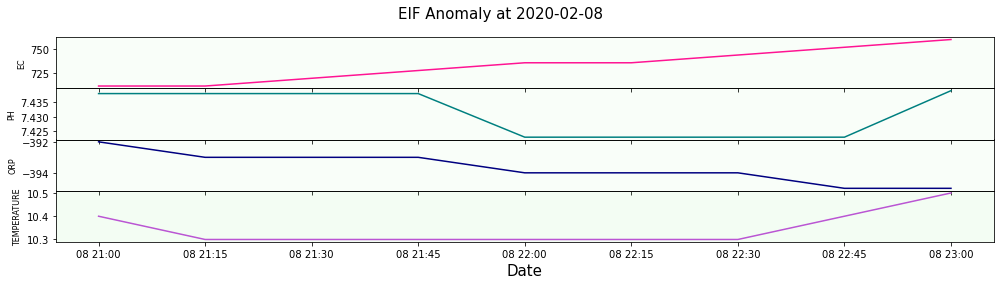

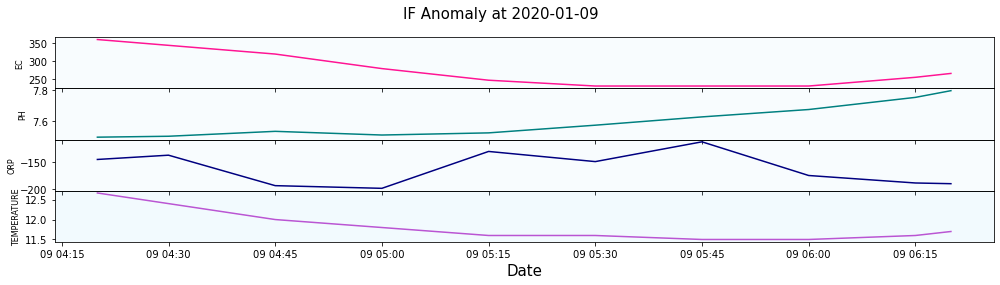

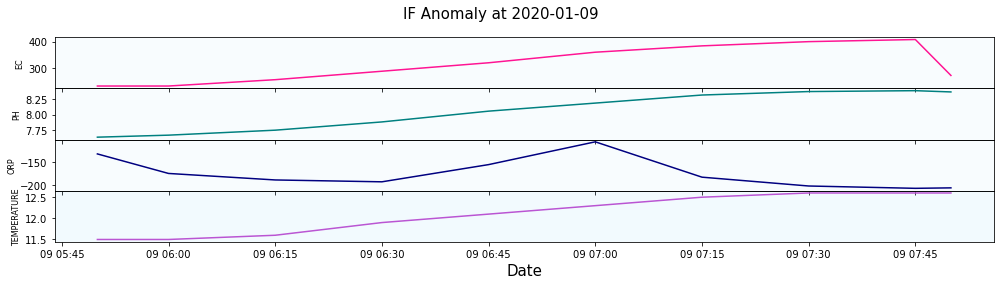

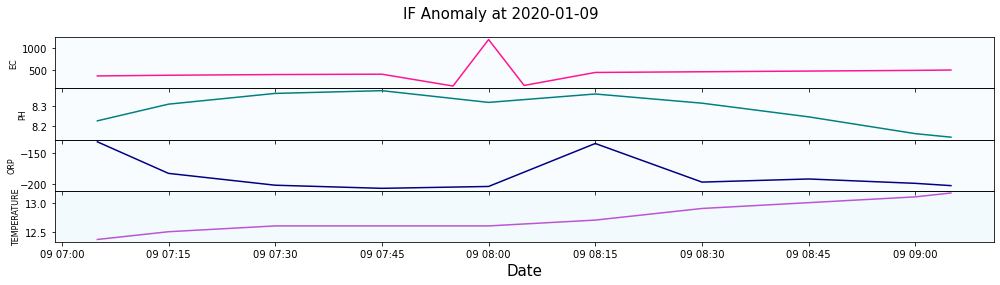

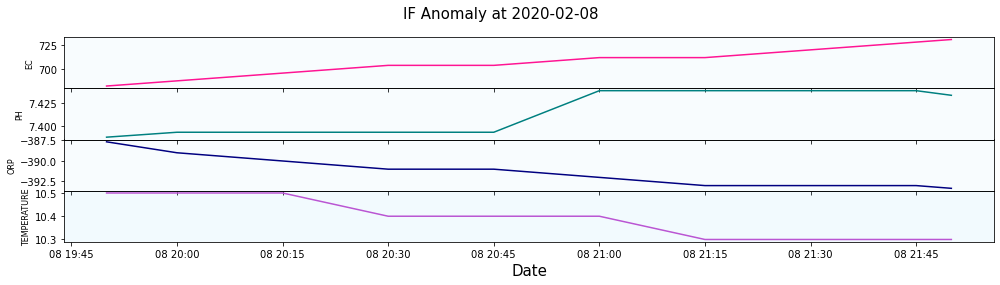

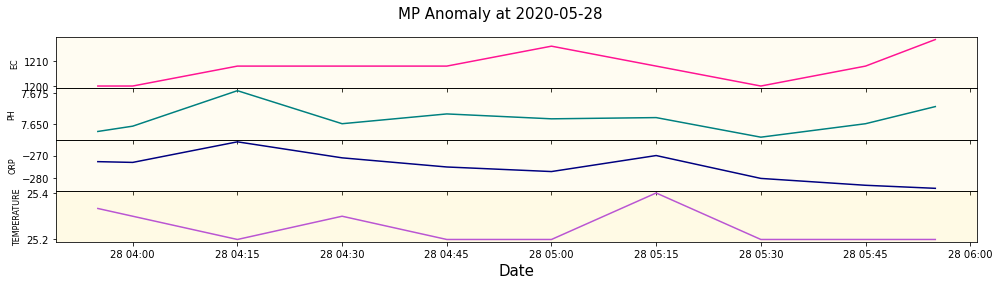

In [10]:
point_df = create_anomaly_df(NODE)
plot_multi_variant_anomalies(point_df)